# Домашнее задание №3

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW3 <Фамилия Имя>**

soft deadline: 21.03.2021T23:59:00+0300

hard deadline: 28.03.2021T23:59:00+0300


In [1]:
!pip3 install opencv-python==4.5.1.48

     |████████████████████████████████| 50.4MB 74kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [3]:
import cv2
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')
import numpy as np
from typing import Tuple
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

from ipywidgets import interact
import ipywidgets as widgets

import os
from sklearn.cluster import KMeans

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Legacy классификация

**Задание 1 (10 баллов)**

Реализуйте функцию, которая строит банк фильтров Габора.
Реализуйте интерактивный инструмент, в котором с помощью 2-х ползунков, один из которых отвечает за угол, другой за масштаб для фильтров из банка, можно выбрать конкретный фильтр и на экране отобразятся:
- Фильтр в пространственной области
- Фильтр в частотном пространстве
- Результат применения этого фильтра к какому-нибудь изображению.

In [ ]:
PATH_TO_IMG = '/content/drive/MyDrive/CV/hw3/stripes.jpg'
stripes = cv2.imread(PATH_TO_IMG)

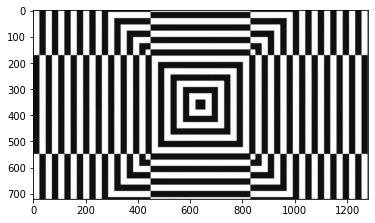

In [ ]:
plt.imshow(stripes)

In [ ]:
def gabor_filter(angle, scale):
    filter = bank[scale, angle]
    # fft = np.fft.fft(filter.astype(float))
    fft = cv2.dft(filter.astype(float), flags=cv2.DFT_COMPLEX_OUTPUT)
    fft_shifted = np.fft.fftshift(fft)
    magnitude_spectrum = np.log(cv2.magnitude(fft_shifted[:, :, 0], fft_shifted[:, :, 1]) + 1e-8)

    img = cv2.imread(PATH_TO_IMG)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    filtered = cv2.filter2D(img, -1, filter)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 45))
    ax1.imshow(filter, cmap="gray")
    ax2.imshow(magnitude_spectrum, cmap="gray")
    ax3.imshow(filtered, cmap="gray")

    ax1.set_title("Filter")
    ax2.set_title("Magnitude spectrum")
    ax3.set_title("Filter applied")

    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()

In [ ]:
def gabor_bank(size : Tuple[int, int], phi_bins, scale_bins, max_scale, min_scale):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """
    filters = np.zeros((scale_bins, phi_bins, *size))
    scales = np.linspace(min_scale, max_scale, scale_bins)
    angles = np.linspace(0, np.pi, phi_bins)
    
    for i, scale in enumerate(scales):
        for j, angle in enumerate(angles):
            sigma = 1.5 / 6 * scale
            theta = angle
            lambda_ = scale
            filter = cv2.getGaborKernel(size, sigma, theta, lambda_, gamma=1, psi=0)
            
            positive = filter > 0
            filter[positive] /= np.sum(filter[positive])
            filter[~positive] /= np.abs(np.sum(filter[~positive]))
            filters[i, j, :, :] = filter.copy()
    return filters

In [ ]:
size = 51
angle_bins = 180
scale_bins = 30
max_scale = 33
min_scale = 3

bank = gabor_bank((size, size), angle_bins, scale_bins, max_scale, min_scale)
angle=widgets.IntSlider(min=0, max=angle_bins - 1, step=1, value=0)
scale=widgets.IntSlider(min=0, max=scale_bins - 1, step=1, value=scale_bins // 2)
interact(gabor_filter, angle=angle, scale=scale)

interactive(children=(IntSlider(value=0, description='angle', max=179), IntSlider(value=15, description='scale…

<function __main__.gabor_filter>

**Задание 2 (15 баллов)** 

Постройте мешок визульных слов на основе SIFT дескртипторов для датасета из третьего задания. Для этого для каждой картинки примените функцию, которая извлекает sift keypoints с дексрипторами, для каждой картинки ограничтесь, например, сотней. Проведите кластеризацию на N(~30) классов, для каждого кластра отбразите в ряду 5 репрезентативных к нему участков изображений, в соответствии с масштабом keypoint-а. отобразите N таких строк.

In [4]:
from tqdm import tqdm 

def read_data(path, num_load = None, colour=True):
    imgs = os.listdir(path)
    if num_load is not None:
        imgs = imgs[:num_load]
    output = [0] * len(imgs)
    # for i, img in enumerate(imgs):
    for i in tqdm(range(len(imgs)), total=len(imgs)):
        img = imgs[i]
        output[i] = cv2.imread(path + "/" + img)
        if not colour:
            output[i] = cv2.cvtColor(output[i], cv2.COLOR_BGR2GRAY)
    return output

In [5]:
PATH_TO_DATA = '/content/drive/MyDrive/CV/hw3/train_val/pic'
# pics = read_data(PATH_TO_DATA)

In [83]:
# pics = imgs
len(pics)

45636

In [86]:
def get_words(imgs, num_points=25, min_diameter=10):
    words = []
    keypoints = []
    indices = []
    sift = cv2.SIFT_create(num_points)
    # for i, img in enumerate(imgs):
    for i in tqdm(range(len(imgs)), total=len(imgs)):
        img = imgs[i]
        if isinstance(img, np.ndarray):
            k, d = sift.detectAndCompute(img, None)
            
            if d is not None and k is not None:
                for j, key in enumerate(k):
                    if key.size >= min_diameter:
                        words.append(d[j])
                        keypoints.append(key)
                        indices.append(i)
    return np.vstack(words), keypoints, indices

In [87]:
words, keypoints, indices = get_words(pics, 100)

100%|██████████| 45636/45636 [06:33<00:00, 115.86it/s]


In [91]:
n_clusters = 35
kmeans = KMeans(n_clusters=n_clusters, random_state=10, verbose=True, n_init=1)
clusters = kmeans.fit_predict(words)
print("finished")

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10583333000.0
start iteration
done sorting
end inner loop
Iteration 1, inertia 10124980000.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 9981801000.0
start iteration
done sorting
end inner loop
Iteration 3, inertia 9915855000.0
start iteration
done sorting
end inner loop
Iteration 4, inertia 9879361000.0
start iteration
done sorting
end inner loop
Iteration 5, inertia 9858299000.0
start iteration
done sorting
end inner loop
Iteration 6, inertia 9845022000.0
start iteration
done sorting
end inner loop
Iteration 7, inertia 9836626000.0
start iteration
done sorting
end inner loop
Iteration 8, inertia 9830654000.0
start iteration
done sorting
end inner loop
Iteration 9, inertia 9825951000.0
start iteration
done sorting
end inner loop
Iteration 10, inertia 9822278000.0
start iteration
done sorting
end inner loop
Iteration 11, inertia 9819329000.0
start iteration
done sorting
end inn

In [92]:
from collections import defaultdict
cl = defaultdict(list)
for i, c in enumerate(clusters):
    cl[c].append(i)

cl = {k: v for k, v in sorted(cl.items(), key=lambda item: item[0])}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


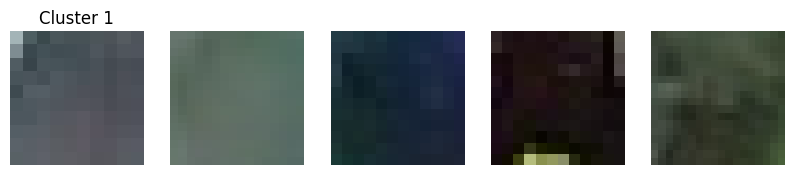

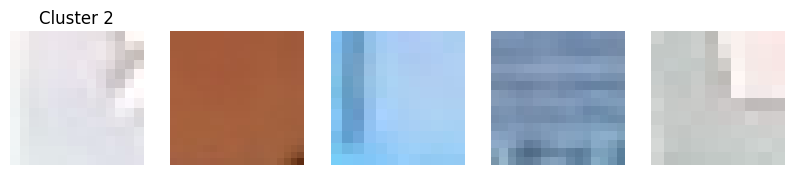

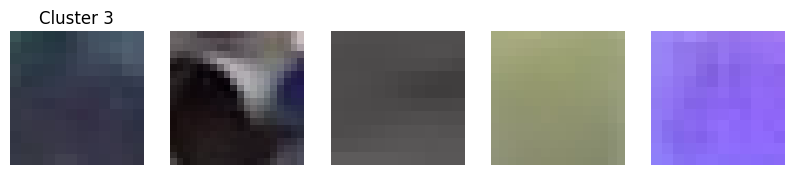

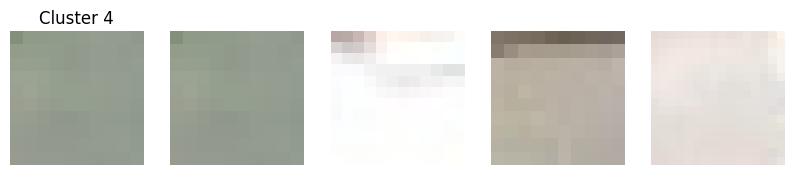

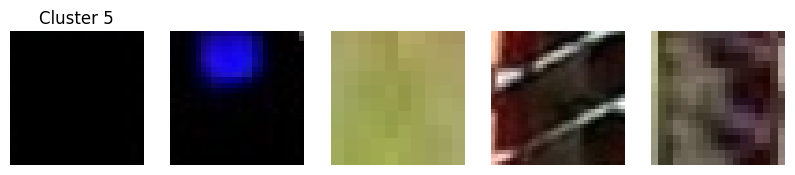

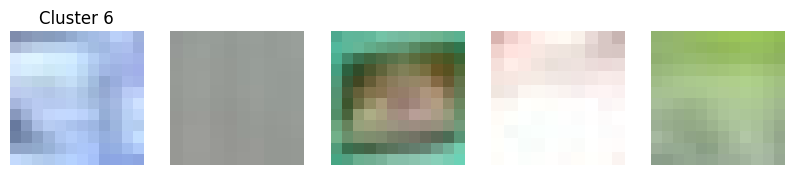

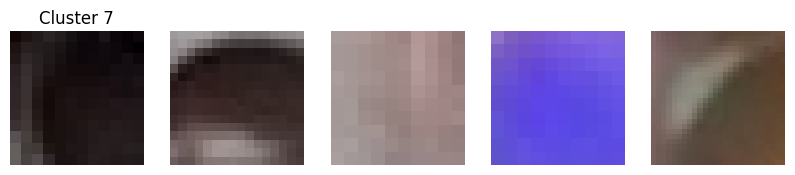

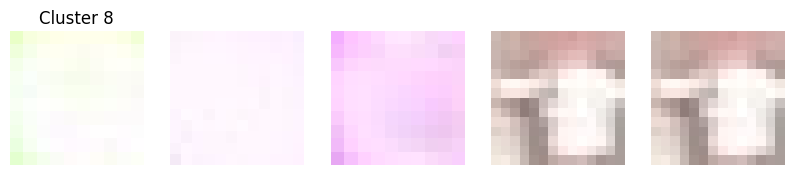

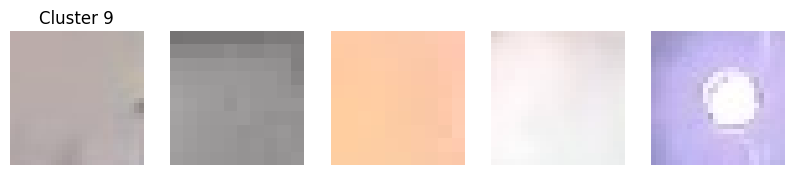

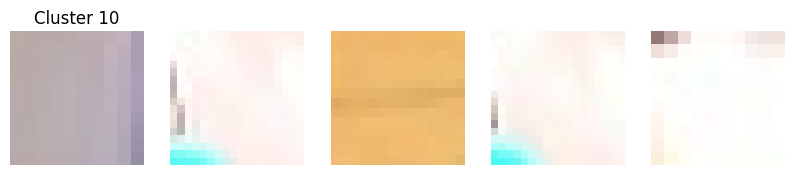

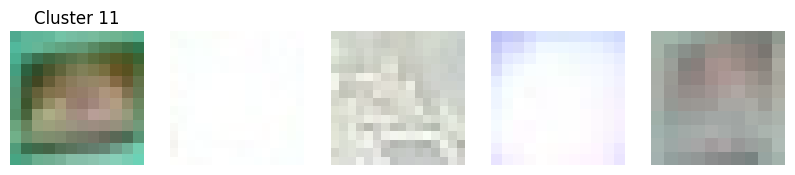

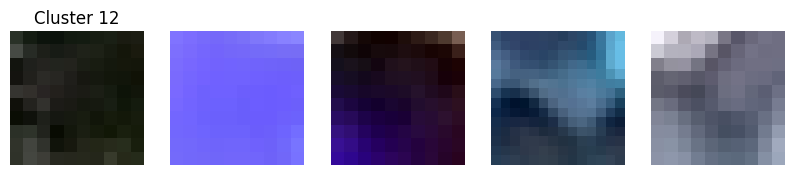

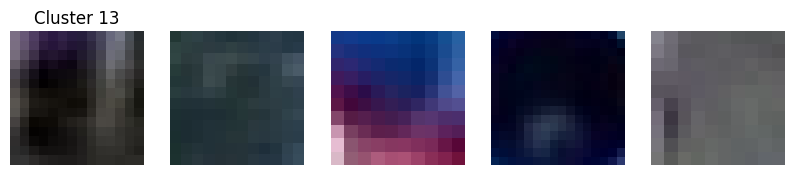

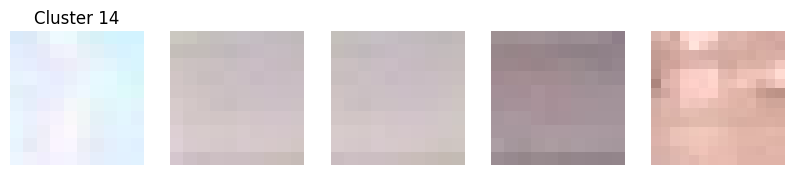

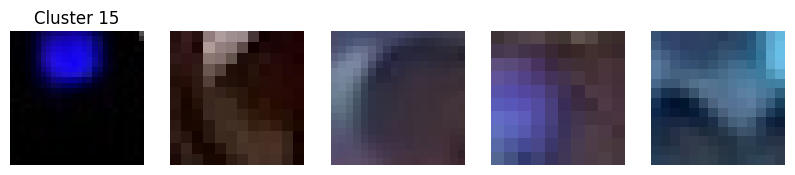

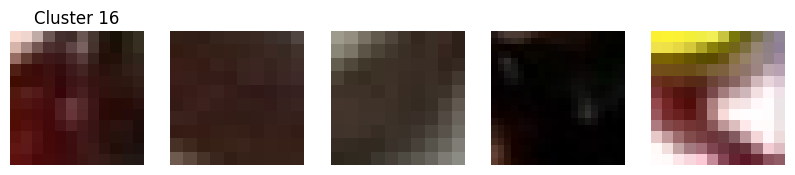

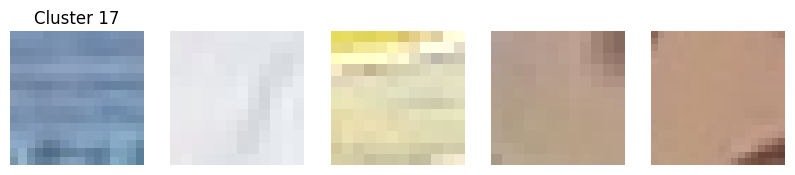

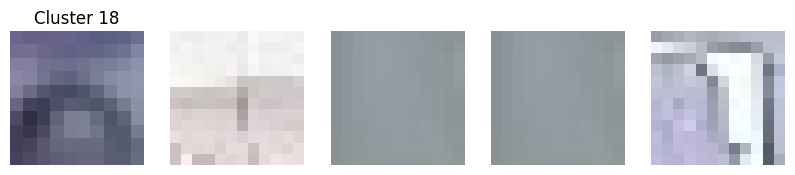

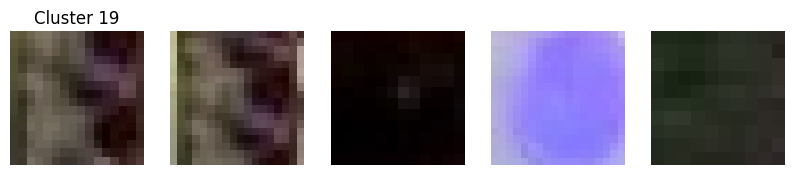

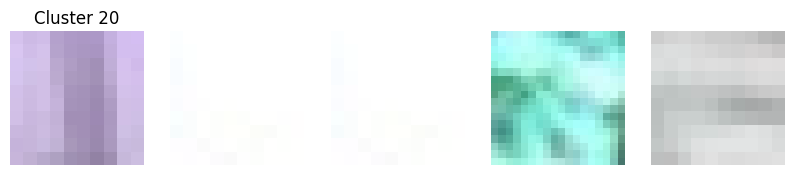

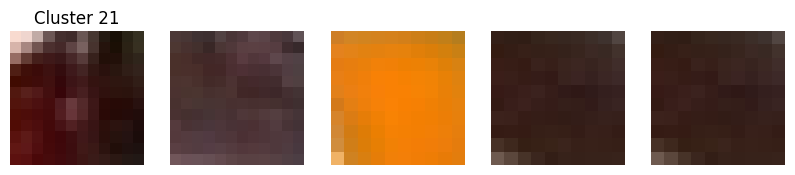

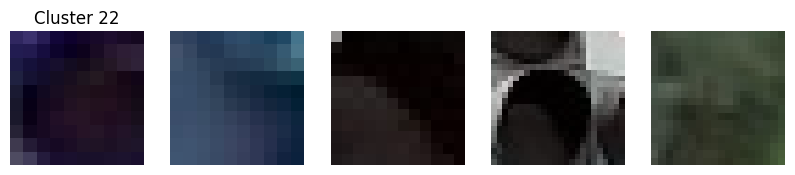

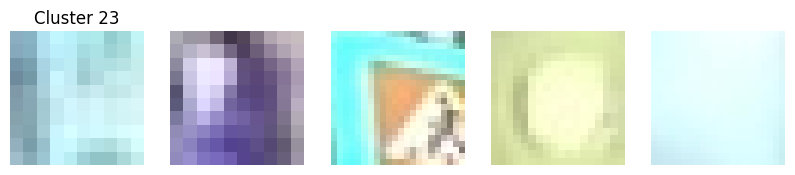

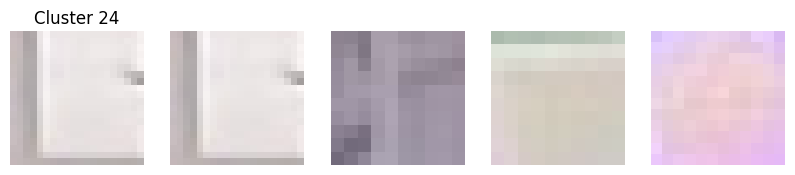

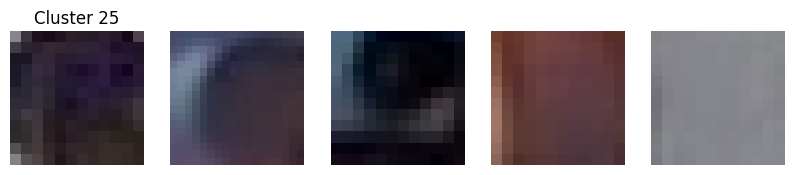

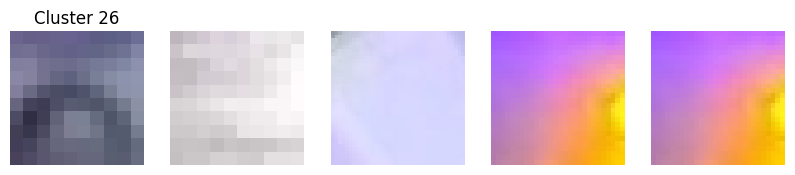

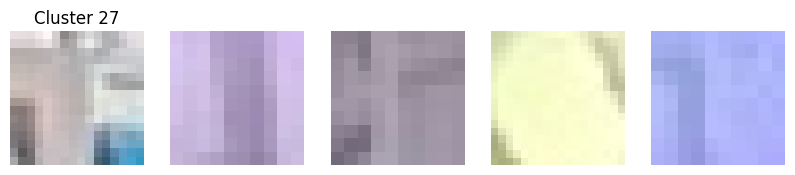

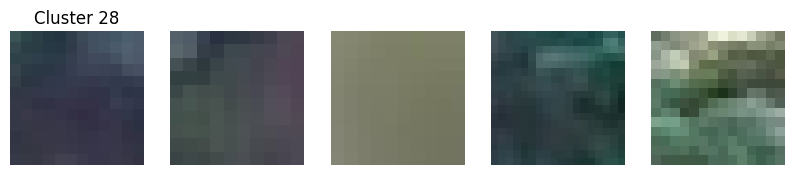

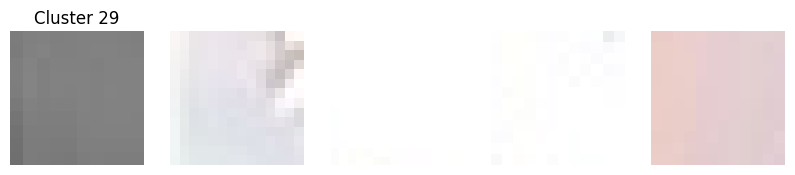

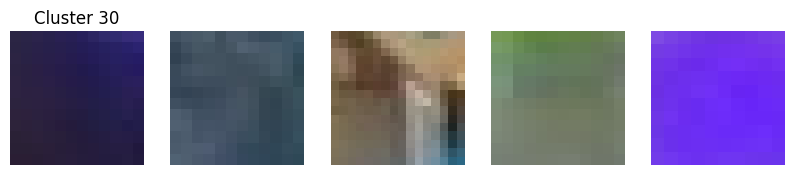

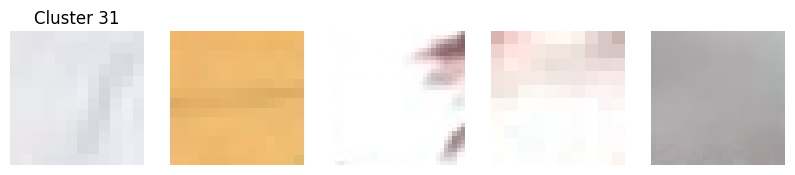

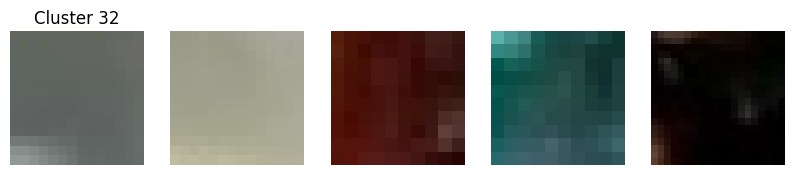

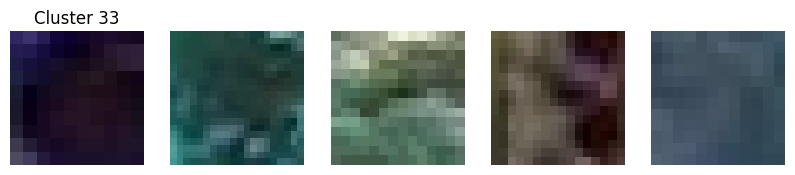

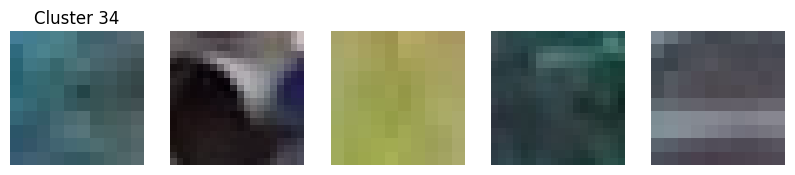

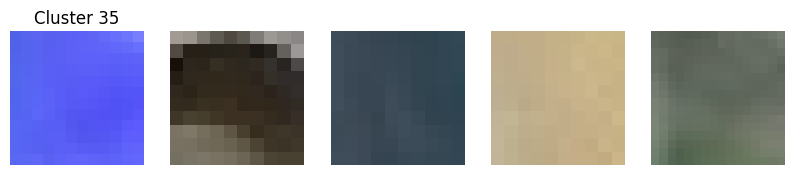

In [93]:
top = 5
for cluster, ind in cl.items():
    fig, axs = plt.subplots(1, top, figsize=(10, 10 * top))
    # fig.suptitle(f"Cluster {cluster + 1}")
    # print(f"Cluster {cluster + 1}")
    for i, idx in enumerate(ind[:top]):
        k = keypoints[idx]
        img = pics[indices[idx]]
        height, width = map(int, k.pt)
        side = int(k.size / 2)
        cropped = img[width - side:width + side, height - side:height + side]

        # axs[i].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        axs[i].imshow(cropped)
        axs[i].set_axis_off()
        if i == 0:
            axs[i].set_title(f"Cluster {cluster + 1}")
plt.show()

**Задание 3 (20 баллов)**

[КОНКУРС](https://youtu.be/8GGWedu77SA?t=3388)

В этом задании вам придется проявить изобретательность. Используйте банки фильтов, мешки визуальных слов и гистрограммы для достижения максимального скора. [Настоящая ссылка на конкурс](https://www.kaggle.com/t/65dc3b38e1194d488ab276752fd1e92d). В этом задании баллы будут распределяться согласно тому, как далеко вы продвинулись на лидерборде. **Важное условие**, весь ваш код положите в этот ноутбук, в нем не должно быть нейросетей =) Только legacy только *hard core*